# Methods (pre DESeq2 analysis)

Using our RNA-seq data, we first quantified the abundance of transcripts using the program kallisto.  [Runs are located at /n/home08/leking/20151019Sackton/KallistoAnalysis/KallistoAnalysisNoMitochondrialTranscripts on Odyssey] The first step was to make a transcriptome index using a transcriptome file (ftp://ftp.flybase.net/genomes/Drosophila_melanogaster/current/fasta/dmel-all-transcript-r6.07.fasta.gz).  Using this transcriptome index and our single-end reads, we were then able to quantify the abundances of transcripts for each strain.  In calculating the abundances of transcripts, we used the following parameters for each strain: the average fragment length for that strain [from RNAseq_cDNAlibraries_Lene.xlsx file sent by e-mail 11/9/15], 30 as an estimate of the standard deviation for each strain, and 100 bootstrap samples.

We found that many mitochondrial transcripts were present at very high levels.  As they were not relevant to our analysis, we removed them.  

After running kallisto, we obtained transcripts per million (tpm) data for each strain of Drosophila.  Analysis of the number of gene transcripts that were not detected showed strain Zi238_C4 as a clear outlier, with too many undetected transcripts.  We removed this strain from our data.  

We then used the library DESeq2 in R for differential expression analysis (see below). 

# Results

A LRT test preferred the reduced model `expression ~lines + tissue + lines:tissue` to the one that included `lane`.  We also showed that if we remove `lane` from our analysis, the p-values don't change very much (correlation of .85 conditioning on carcass data, and .90 conditioning on testes data).  [See: 20160122_IR_Testing_Lane.ipynb]  The biggest differences in gene expression are due to tissue type (carcass or testes).  In fact, the differences between tissues were so great that we decided it was more conservative to analyze carcass and tissue data separately.  In fact, analyzing tissues separately yields to significantly genes being labeled as differentially expressed.

Conditioning on carcass data, we find 463 statistically significantly differerentially expressed genes per line using the simple model with only `lines` as an indepedent variable.  We define statistical significance to be all transcripts with an adjusted p-value <.05.  Analysis of testes data did not show the same level of differential expression by line, with only 150 statistically significant genes.  

A heatmap and PCA plot of the carcass data reveal that inter-population variation is not a significant source of variation in the Y-line -- there is also significant intra-population variation.  In order to show this, we bootstrap our most differentially expressed genes by line.  We then restrict our analysis to only pairs of lines (e.g. Fr188 vs Fr89; Fr188 vs Zi257; etc ... ), and run 2-means clustering.  We calculate the accuracy of the clustering algorithm in separating lines of a same and of different countries [SHOW THIS].

Because there are not many SNPs in the Zimbabwe population (Larracuente and Clark, 2013), we can attribute differences in gene expression to other kinds of muational events (for example differences in the number of repetitive elements).  The same pattern was not as readily available in the testes data [SHOW THIS].

We compare the statistically significant genes found in the analysis of carcass data, with those described in the meta-analysis of Sackton and Hartl (2013).  To do this, we first convert the transcripts into unique gene IDs using the converter at: http://flybase.org/static_pages/downloads/IDConv.html.  We also update the gene IDs used in the meta-analysis.  A Fisher's exact test reveals that there is significant overlap between the differentially expressed genes per line found in our experiment, and those exhibiting Y-regulatory variation as described in the meta-analysis in Sackton and Hartl (2013) (p-value <.001). 

The next step is to see whether the differentially expressed genes we find in this analysis correlate with those that bind to the DAM protein, pointing to a mechanism as to how the Y chromosome affects gene expression in the autosomes.

# Issues in my analysis


1.  When comparing significant genes in our analysis to those in the GBE analysis, we run into a couple of problems.  Our adjusted p-values are probably not right.  Indeed, we considered the genes that were significant out of a much wider range of genes than in the GBE dataset.  Also, some genes needed to be updated, so again this would affect our p-values.  I think the point though was just to show that we are finding reasonable candidates, which based on the Fisher's exact test, it seems like we are.

2.  In 20160122_IR_Testing_Lane.ipynb, the scatterplot of p-values with and without lane is an arc, not a line, in the carcass data.

# DESeq2 Differential Expression Analysis

## Importing libraries, importing and formatting Kallisto data and condition information

In [1]:
#From:http://software.rc.fas.harvard.edu/ngsdata/workshops/2015_March/DESeq2_fruitfly.html
suppressWarnings(library('ggplot2'))
suppressWarnings(library('DESeq2'))
library('RColorBrewer')

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel
Note: the specification for S3 class “AsIs” in package ‘BiocGenerics’ seems equivalent to one from package ‘jsonlite’: not turning on duplicate class definitions for this class.

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, as.vector, cbind, colnames,
    do.call, duplicated, eval, evalq, Filter, Find, get, grep, grepl,
    intersect, is.unsorted, lapply, lengths, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,

Grabbing files from Kallisto run (as described in methods).  Note that we remove strain Zi238_C4, which had too many undetected transcripts.


In [3]:
base_dir <- "~/Desktop/KallistoFiles/results2"
sample_names1<-list.files(base_dir)
sample_names1<-sample_names1[sample_names1!="Zi238_C4_AGTTCC"]  #We remove strain Zi238_C4, as there were too many tpms = 0
sample_names<-gsub('.{7}$', '', sample_names1)
kal_dirs <- sapply(sample_names1, function(id) file.path(base_dir, id))

We create a dataframe called `countData` to store the tpms (converted to integers) from these files.   `countData` rows are transcript ids, columns are particular strain and replicate (e.g. Fr89_C2).  In this table, there are 30433 rows, corresponding to the number of transcript ids, and 25 columns, corresponding to the different strains/replicates.

In [5]:
#variable countData: all of the tpm info for all of the Kallisto files, rounded to integers.
countData <- as.character(read.table(file.path(kal_dirs[1], "abundance.tsv"), header = TRUE)$target_id)
for (dir in kal_dirs){
  z<-read.table(file.path(dir, "abundance.tsv"), header=TRUE)
  countData<-data.frame(countData, as.integer(z$est_counts))  #converting to integers
}

#Setting row and column names for countData
colnames(countData)=c("target_id", sample_names)
countData$target_id=read.table(file.path(kal_dirs[1], "abundance.tsv"), header = TRUE)$target_id
rownames(countData)=countData$target_id
countData$target_id=NULL

dim(countData)

[1] 30433    25

We now load conditions file, and display it below.  We store it in the variable `colData`.

In [6]:
#variable colData: All of the conditions information for the different samples

#The conditions dataset is hiseq_infoAll
colData<-read.table("~/Desktop/KallistoFiles/hiseq_infoAll.txt", header=T, stringsAsFactors=FALSE, sep="\t")
colData<-colData[match(colnames(countData), gsub('.{7}$', '', colData$sample)),]

rownames(colData)=gsub('.{7}$', '', colData$sample)
colData$sample = NULL
colData$lane = factor(colData$lane)
colData$lines = factor(colData$lines)

colData

country lines tissue lane
Fr188_C1      Fr   188      C    1
Fr188_C2      Fr   188      C    2
Fr188_C3      Fr   188      C    1
Fr188_T3      Fr   188      T    1
Fr188_T5      Fr   188      T    2
Fr188_T6      Fr   188      T    2
Fr89_C1       Fr    89      C    2
Fr89_C2       Fr    89      C    2
Fr89_C4       Fr    89      C    1
Fr89_T3       Fr    89      T    1
Fr89_T4       Fr    89      T    1
Fr89_T5       Fr    89      T    2
Zi238_C1      Zi   238      C    2
Zi238_C2      Zi   238      C    2
Zi238_C3      Zi   238      C    2
Zi238_T2      Zi   238      T    1
Zi238_T3      Zi   238      T    2
Zi238_T4      Zi   238      T    1
Zi257_C1      Zi   257      C    1
Zi257_C2      Zi   257      C    2
Zi257_C3      Zi   257      C    1
Zi257_T1      Zi   257      T    1
Zi257_T2      Zi   257      T    2
Zi257_T3      Zi   257      T    1
Zi257_T4      Zi   257      T    2

## Testing the significance of lane

### LRT test

We are first of all interested to know, as a sanity check, if lane has an effect.  In order to do this, we run a LRT to see which model is better: the full (~lines + tissue + lines:tissue + lane) or the reduced (~lines + tissue + lines:tissue).  We find that we prefer the smaller model (lines + tissue + lines:tissue).

In [231]:
dataset <- DESeqDataSetFromMatrix(countData = countData,
                                          colData = colData,
                                          design = ~lines + tissue+ lines:tissue + lane)
dds<-DESeq(dataset)

Warning message:
In DESeqDataSet(se, design = design, ignoreRank): some variables in design formula are characters, converting to factorsestimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


In [232]:
testingLane<-nbinomLRT(dds, reduced=~lines + tissue + lines:tissue)
results.testingLane<-results(testingLane)
summary(results.testingLane)



found results columns, replacing these



out of 29820 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)     : 11, 0.037% 
LFC < 0 (down)   : 1, 0.0034% 
outliers [1]     : 346, 1.2% 
low counts [2]   : 2887, 9.7% 
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 29820 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)     : 1580, 5.3% 
LFC < 0 (down)   : 420, 1.4% 
outliers [1]     : 346, 1.2% 
low counts [2]   : 3460, 12% 
(mean count < 3)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



### Correlation of p-values

We also showed that if we remove `lane` from our analysis, the p-values don't change very much.

## DESeq analysis with lane

### Separating testes and carcass data

We found in a preliminary exploratory data analysis that the biggest differences in gene expression are between carcass and testes.  In fact the differences are so big, that we find it more conservative to divide our dataset into carcass data and testes data.

We also create, for each tissue, DESeq datasets conditioning on `lines` and `lane`.  `lane` is a control - we expect it to have no effect.  Later we will test if this is actually the case.

In [8]:
##dataset C -- just carcass data
colDataC<-colData[colData$tissue=='C',]
countDataC<-countData[,colnames(countData) %in% rownames(colDataC)]
datasetC <- DESeqDataSetFromMatrix(countData = countDataC,
                                   colData = colDataC,
                                   design = ~lines + lane)

##dataset T -- just testes data
colDataT<-colData[colData$tissue=='T',]
countDataT<-countData[,colnames(countData) %in% rownames(colDataT)]
datasetT <- DESeqDataSetFromMatrix(countData = countDataT,
                                   colData = colDataT,
                                   design = ~lines + lane)

### Creating DESeq object files from our DESeq datasets

Here we create DESeq object files from our DESeq datasets.

In [9]:
ddsC<-DESeq(datasetC)

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


In [10]:
ddsT<-DESeq(datasetT)

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.
final dispersion estimates
fitting model and testing


### Pairwise comparisons in carcass and testes data

We constrast different lines with the carcass data.  The biggest difference is between 257 and 238.

In [11]:
print("lane 1 vs 2 (control)")
summary(results(ddsC, contrast=c('lane','1','2')), alpha=0.05)

print("lines 188 vs 238")
summary(results(ddsC, contrast=c('lines','188','238')), alpha=0.05) #nothing
print("lines 188 vs 89")
summary(results(ddsC, contrast=c('lines','188','89')), alpha=0.05) #nothing
print("lines 188 vs 257")
summary(results(ddsC, contrast=c('lines','188','257')), alpha=0.05) #something
print("lines 257 vs 238")
summary(results(ddsC, contrast=c('lines','257','238')), alpha=0.05) #something bigger
print("lines 257 vs 89")
summary(results(ddsC, contrast=c('lines','257','89')), alpha=0.05) #something 
print("lines 89 vs 238")
summary(results(ddsC, contrast=c('lines','89', '238')), alpha=0.05) #something

[1] "lane 1 vs 2 (control)"

out of 28822 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)     : 13, 0.045% 
LFC < 0 (down)   : 11, 0.038% 
outliers [1]     : 634, 2.2% 
low counts [2]   : 3225, 11% 
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "lines 188 vs 238"

out of 28822 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)     : 20, 0.069% 
LFC < 0 (down)   : 11, 0.038% 
outliers [1]     : 634, 2.2% 
low counts [2]   : 0, 0% 
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "lines 188 vs 89"

out of 28822 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)     : 6, 0.021% 
LFC < 0 (down)   : 11, 0.038% 
outliers [1]     : 634, 2.2% 
low counts [2]   : 2707, 9.4% 
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "lines 188 vs 257"

We contrast different lines with the testes data -- all the effects are smaller, and the biggest effect is again 257 vs 238

In [12]:
print("lane 1 vs 2 (control)")
summary(results(ddsT, contrast=c('lane','1','2')), alpha=0.05)

print("lines 188 vs 238")
summary(results(ddsT, contrast=c('lines','188','238')), alpha=0.05) 
print("lines 188 vs 89")
summary(results(ddsT, contrast=c('lines','188','89')), alpha=0.05) 
print("lines 188 vs 257")
summary(results(ddsT, contrast=c('lines','188','257')), alpha=0.05) 
print("lines 257 vs 238")
summary(results(ddsT, contrast=c('lines','257','238')), alpha=0.05) #biggest effect (still not very big)
print("lines 257 vs 89")
summary(results(ddsT, contrast=c('lines','257','89')), alpha=0.05)  
print("lines 89 vs 238")
summary(results(ddsT, contrast=c('lines','89', '238')), alpha=0.05) 

[1] "lane 1 vs 2 (control)"

out of 28486 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)     : 23, 0.081% 
LFC < 0 (down)   : 30, 0.11% 
outliers [1]     : 0, 0% 
low counts [2]   : 18160, 64% 
(mean count < 76)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "lines 188 vs 238"

out of 28486 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)     : 14, 0.049% 
LFC < 0 (down)   : 19, 0.067% 
outliers [1]     : 0, 0% 
low counts [2]   : 0, 0% 
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "lines 188 vs 89"

out of 28486 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)     : 12, 0.042% 
LFC < 0 (down)   : 21, 0.074% 
outliers [1]     : 0, 0% 
low counts [2]   : 546, 1.9% 
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "lines 188 vs 257"

out of 28

### LRT to see if line is significant in testes vs carcass data

From above (well, two cells up), we see that mostly there is a difference per line in the carcass data.  We do a LRT to see if line is significant, compared to the reduced model.

In [13]:
#variable rownames(results.line.ordered.C): the top genes (by adjusted pval) that show a difference by line in the carcass data

#line test for carcass
ddsC.line<-nbinomLRT(ddsC, reduced=~lane)
results.line.C<-results(ddsC.line)
results.line.ordered.C<-results.line.C[order(results.line.C$padj),]
summary(results.line.C)

found results columns, replacing these



out of 28822 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)     : 266, 0.92% 
LFC < 0 (down)   : 593, 2.1% 
outliers [1]     : 251, 0.87% 
low counts [2]   : 3343, 12% 
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [14]:
#line test for testes
ddsT.line<-nbinomLRT(ddsT, reduced=~lane)
results.line.T<-results(ddsT.line)
results.line.ordered.T<-results.line.T[order(results.line.T$padj),]
summary(results.line.T)

found results columns, replacing these



out of 28486 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)     : 152, 0.53% 
LFC < 0 (down)   : 150, 0.53% 
outliers [1]     : 0, 0% 
low counts [2]   : 2202, 7.7% 
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



From the above, we see that line has a much smaller effect in the testes data than in carcass data.

## Removing lane

In [15]:
##dataset C -- just carcass data
colDataC<-colData[colData$tissue=='C',]
countDataC<-countData[,colnames(countData) %in% rownames(colDataC)]
datasetC <- DESeqDataSetFromMatrix(countData = countDataC,
                                   colData = colDataC,
                                   design = ~lines)

##dataset T -- just testes data
colDataT<-colData[colData$tissue=='T',]
countDataT<-countData[,colnames(countData) %in% rownames(colDataT)]
datasetT <- DESeqDataSetFromMatrix(countData = countDataT,
                                   colData = colDataT,
                                   design = ~lines)
suppressWarnings(ddsC<-DESeq(datasetC))
suppressWarnings(ddsT<-DESeq(datasetT))

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


In [16]:
ddsC.line<-nbinomLRT(ddsC, reduced= ~1)
results.line.C<-results(ddsC.line)
results.line.ordered.C<-results.line.C[order(results.line.C$padj),]
summary(results.line.C)

found results columns, replacing these



out of 28822 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)     : 321, 1.1% 
LFC < 0 (down)   : 440, 1.5% 
outliers [1]     : 409, 1.4% 
low counts [2]   : 4433, 15% 
(mean count < 3)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [17]:
#line test for testes
ddsT.line<-nbinomLRT(ddsT, reduced=~1)
results.line.T<-results(ddsT.line)
results.line.ordered.T<-results.line.T[order(results.line.T$padj),]
summary(results.line.T)

found results columns, replacing these



out of 28486 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)     : 102, 0.36% 
LFC < 0 (down)   : 97, 0.34% 
outliers [1]     : 522, 1.8% 
low counts [2]   : 2202, 7.7% 
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [18]:
print("lines 188 vs 238")
summary(results(ddsC, contrast=c('lines','188','238')), alpha=0.05) #nothing
print("lines 188 vs 89")
summary(results(ddsC, contrast=c('lines','188','89')), alpha=0.05) #nothing
print("lines 188 vs 257")
summary(results(ddsC, contrast=c('lines','188','257')), alpha=0.05) #something
print("lines 257 vs 238")
summary(results(ddsC, contrast=c('lines','257','238')), alpha=0.05) #something bigger
print("lines 257 vs 89")
summary(results(ddsC, contrast=c('lines','257','89')), alpha=0.05) #something 
print("lines 89 vs 238")
summary(results(ddsC, contrast=c('lines','89', '238')), alpha=0.05) #something

[1] "lines 188 vs 238"

out of 28822 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)     : 29, 0.1% 
LFC < 0 (down)   : 12, 0.042% 
outliers [1]     : 1827, 6.3% 
low counts [2]   : 0, 0% 
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "lines 188 vs 89"

out of 28822 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)     : 8, 0.028% 
LFC < 0 (down)   : 10, 0.035% 
outliers [1]     : 1827, 6.3% 
low counts [2]   : 0, 0% 
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "lines 188 vs 257"

out of 28822 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)     : 33, 0.11% 
LFC < 0 (down)   : 40, 0.14% 
outliers [1]     : 1827, 6.3% 
low counts [2]   : 1836, 6.4% 
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "lines 257 vs 238"

out of 2

In [19]:
print("lines 188 vs 238")
summary(results(ddsT, contrast=c('lines','188','238')), alpha=0.05) 
print("lines 188 vs 89")
summary(results(ddsT, contrast=c('lines','188','89')), alpha=0.05) 
print("lines 188 vs 257")
summary(results(ddsT, contrast=c('lines','188','257')), alpha=0.05) 
print("lines 257 vs 238")
summary(results(ddsT, contrast=c('lines','257','238')), alpha=0.05) #biggest effect (still not very big)
print("lines 257 vs 89")
summary(results(ddsT, contrast=c('lines','257','89')), alpha=0.05)  
print("lines 89 vs 238")
summary(results(ddsT, contrast=c('lines','89', '238')), alpha=0.05) 

[1] "lines 188 vs 238"

out of 28486 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)     : 6, 0.021% 
LFC < 0 (down)   : 7, 0.025% 
outliers [1]     : 2239, 7.9% 
low counts [2]   : 11622, 41% 
(mean count < 30)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "lines 188 vs 89"

out of 28486 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)     : 9, 0.032% 
LFC < 0 (down)   : 11, 0.039% 
outliers [1]     : 2239, 7.9% 
low counts [2]   : 0, 0% 
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "lines 188 vs 257"

out of 28486 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)     : 15, 0.053% 
LFC < 0 (down)   : 16, 0.056% 
outliers [1]     : 2239, 7.9% 
low counts [2]   : 539, 1.9% 
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "lines 257 vs 238"

o

## Combining Carcass and Testes

I am confused.  `dds` was tissue:lines + lines + tissue.  Why are so many genes significant in this framework?

In [233]:
dds.line<-nbinomLRT(dds, reduced= ~tissue)
results.line<-results(dds.line)
results.line.ordered<-results.line[order(results.line$padj),]
summary(results.line)

found results columns, replacing these



out of 29820 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)     : 1934, 6.5% 
LFC < 0 (down)   : 917, 3.1% 
outliers [1]     : 346, 1.2% 
low counts [2]   : 3460, 12% 
(mean count < 3)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [234]:
NoNA<-results.line.ordered[complete.cases(results.line.ordered$padj),]
length(NoNA[NoNA$padj<.05,][,1])

[1] 2170

## Plotting differences

Now we do a heatmap on the 463 most differentially expressed genes by lines in the carcass data (all those with p_adj <.05).  We see that Zi238 seems more related to the French strains than to Zi257.  But then again, Fr89_C4 shows up as closely related to the 257 strains.  (The picture was cleaner when we conditioned on lane).

We notice that Fr89_C4, and to some extent Zi238_C2 have a whole bunch of underexpressed genes relative to the other strains.  These are not strains that were flagged by our preliminary analysis in python as having too many zeros (see 20151027_EDA.ipynb).  [The other strain pointed out by the our preliminary analysis in python as having maybe too many zeros was Fr188_T3].  

[1] 463

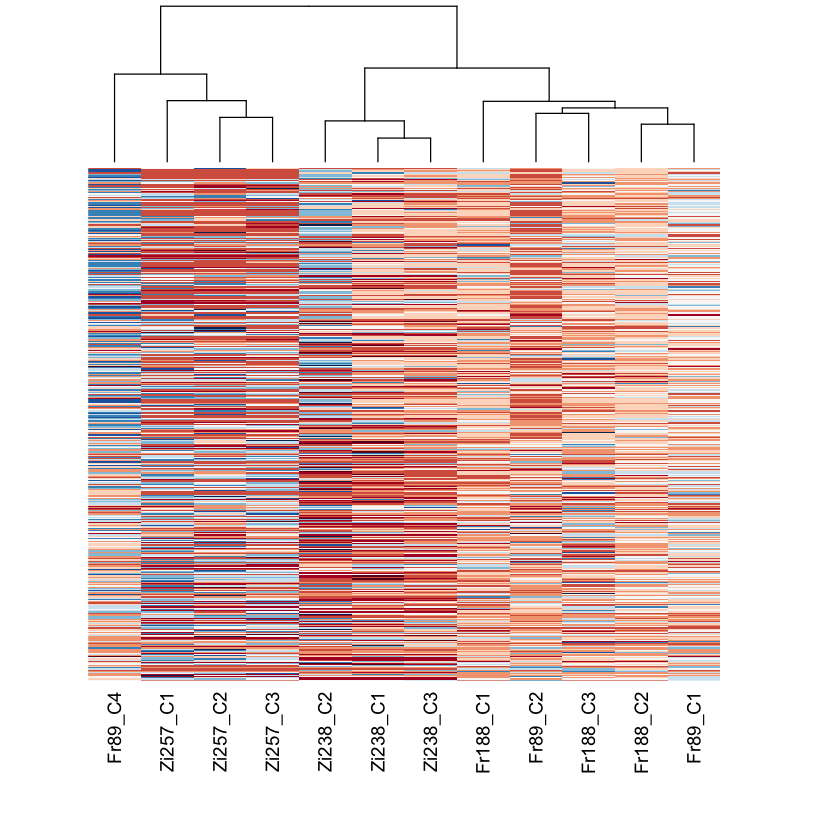

In [25]:
NoNAC<-results.line.ordered.C[complete.cases(results.line.ordered.C$padj),]
length(NoNAC[NoNAC$padj<.05,][,1])

hmcol <- brewer.pal(11,'RdBu')
nCountsC <- counts(ddsC, normalized=TRUE)
heatmap(as.matrix(nCountsC[rownames(results.line.ordered.C)[1:length(NoNAC[NoNAC$padj<.05,][,1])], ]), 
        Rowv = NA, 
        col = hmcol, 
        mar = c(8,2), 
        labRow = "")

We do the same for the testes data (there are 150 genes w/ transcripts <.05), and we see some clustering by line. Here Zi238 looks closer to Fr188.  Fr89 and Zi257 are also pretty tight.  This is not the same pattern as we see in the carcass data.

[1] 150

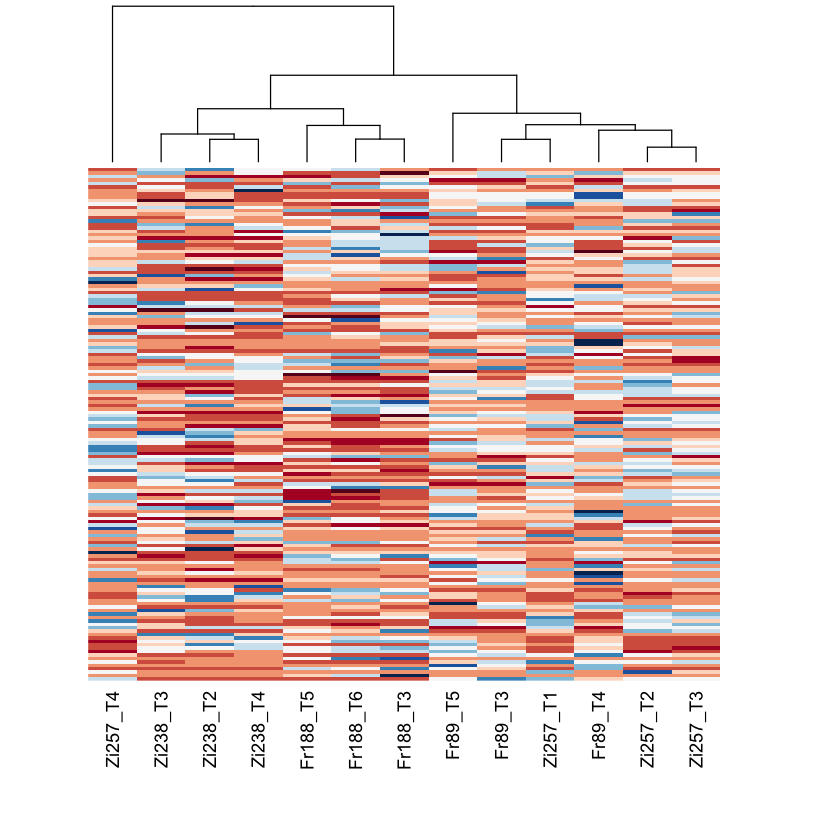

In [26]:
NoNAT<-results.line.ordered.T[complete.cases(results.line.ordered.T$padj),]
length(NoNAT[NoNAT$padj<.05,][,1])

hmcol <- brewer.pal(11,'RdBu')
nCountsT <- counts(ddsT, normalized=TRUE)
heatmap(as.matrix(nCountsT[rownames(results.line.ordered.T)[1:length(NoNAT[NoNAT$padj<.05,][,1])], ]), 
        Rowv = NA, col = hmcol, mar = c(8,2), labRow="")

We talked about being more stringent in removing outliers (the other strain that potentially looked like an outlier in the python EDA was Fr188_T3), but it seems like Fr188_T3 falls where it's supposed to.

Combining testes and carcass data into one heatmap (I'm not entirely sure if this visual is interesting)

In [27]:
datasetBoth <- DESeqDataSetFromMatrix(countData = countData,
                                   colData = colData,
                                   design = ~lines)
ddsBoth<-DESeq(datasetBoth)

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 874 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


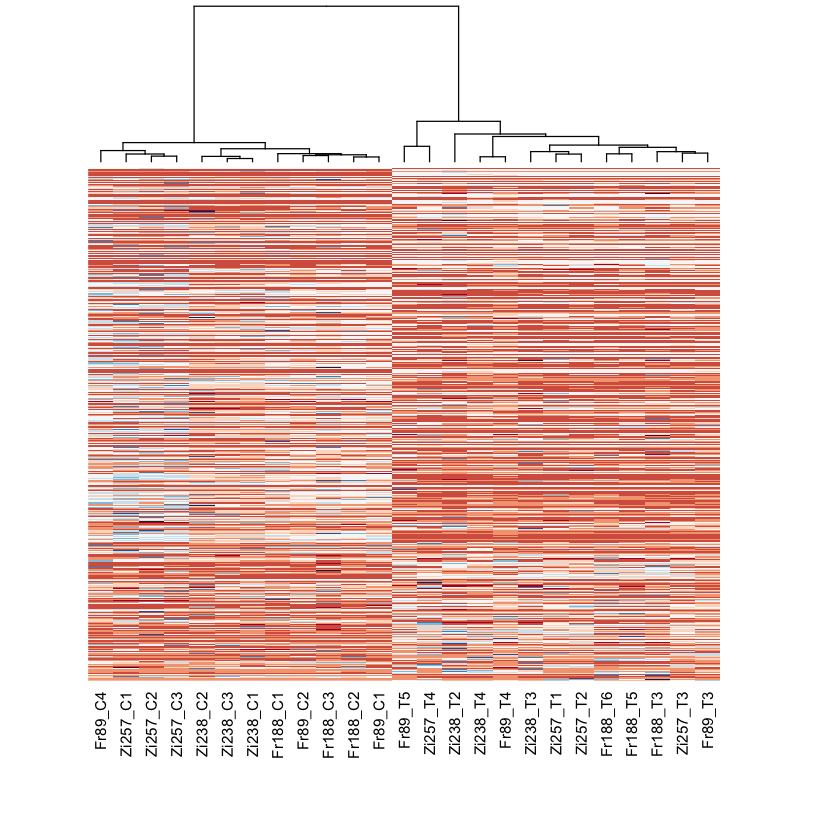

In [31]:
hmcol <- brewer.pal(11,'RdBu')
nCountsBoth <- counts(ddsBoth, normalized=TRUE)
SigsInCandT<-union(rownames(results.line.ordered.T)[1:length(NoNAT[NoNAT$padj<.05,][,1])], 
          rownames(results.line.ordered.C)[1:length(NoNAC[NoNAC$padj<.05,][,1])])


heatmap(as.matrix(nCountsBoth[SigsInCandT, ]), 
        Rowv = NA, col = hmcol, mar = c(8,2), labRow="")

Now we plot a PCA using the 463 most differentially expressed genes by line for the carcass data.  Looks like PCA2 maybe shows a country effect, but I'm not all that convinced.

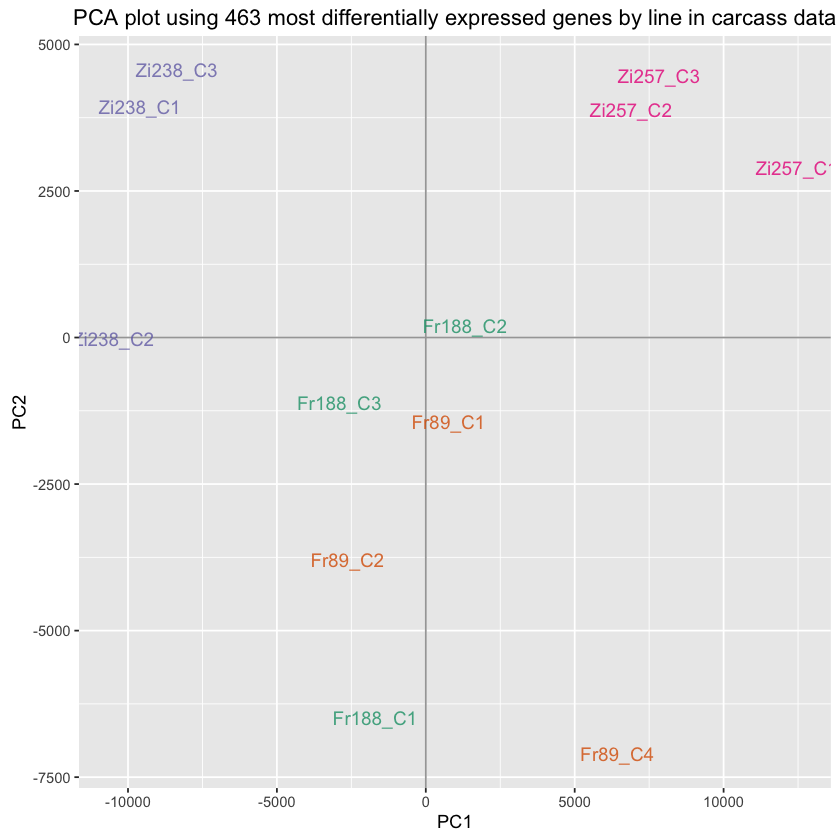

In [225]:
#library(RColorBrewer)
#display.brewer.all()
#brewer.pal(4, "Dark2")

#get normalized counts
pca1<-prcomp(t(as.matrix(nCountsC[rownames(results.line.ordered.C)[1:463], ])))
scores = as.data.frame(pca1$x)


cols=c(rep('#1B9E77',3), rep('#D95F02',3),rep('#7570B3',3),rep('#E7298A',3))
# plot of observations
ggplot(data = scores, aes(x = PC1, y = PC2, label = rownames(scores))) +
  geom_hline(yintercept = 0, colour = "gray65") +
  geom_vline(xintercept = 0, colour = "gray65") +
  geom_text(colour =cols, alpha = 0.8, size = 4) +
  ggtitle("PCA plot using 463 most differentially expressed genes by line in carcass data")

We do the same for testes data, and it seems like you don't see  all that much separation in the testes data.

[1] "Fr188_T3" "Fr188_T5" "Fr188_T6" "Fr89_T3"  "Fr89_T4"  "Fr89_T5" 
 [7] "Zi238_T2" "Zi238_T3" "Zi238_T4" "Zi257_T1" "Zi257_T2" "Zi257_T3"
[13] "Zi257_T4"

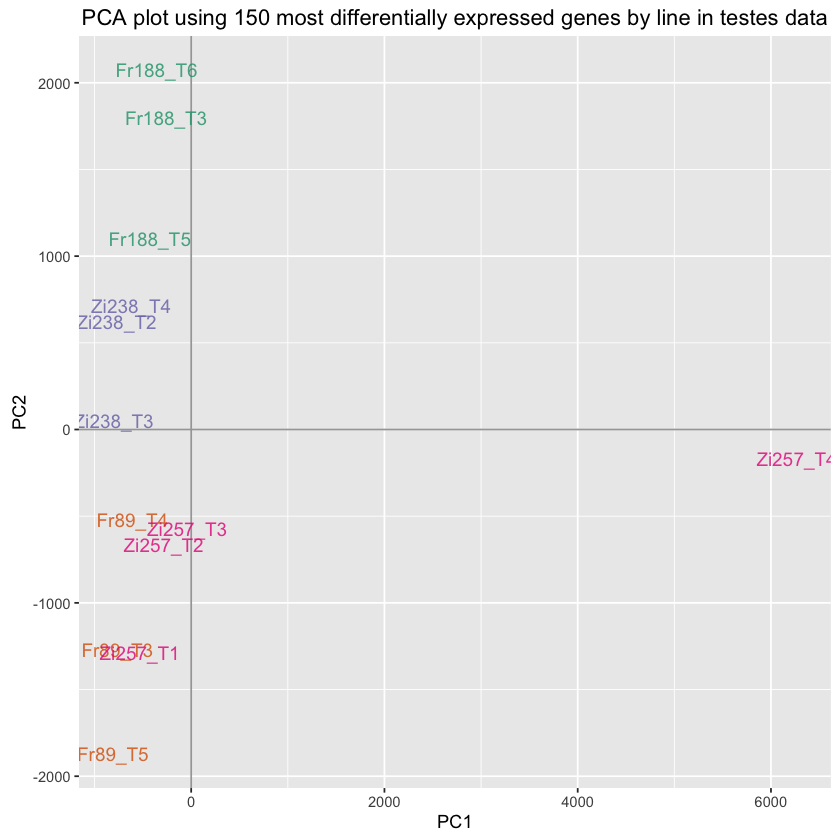

In [220]:
#get normalized counts
pca1<-prcomp(t(as.matrix(nCountsT[rownames(results.line.ordered.T)[1:150], ])))
scores = data.frame(pca1$x)
cols=c(rep('#1B9E77',3), rep('#D95F02',3),rep('#7570B3',3),rep('#E7298A',4))
# plot of observations
rownames(scores)
ggplot(data = scores, aes(x = PC1, y = PC2, label = rownames(scores))) +
  geom_hline(yintercept = 0, colour = "gray65") +
  geom_vline(xintercept = 0, colour = "gray65") +
  geom_text(alpha = 0.8, size = 4, colour=cols) +
  ggtitle("PCA plot using 150 most differentially expressed genes by line in testes data")


PCA plot along all genes that were differentially expressed in carcass and testes data (not sure this is adding value)

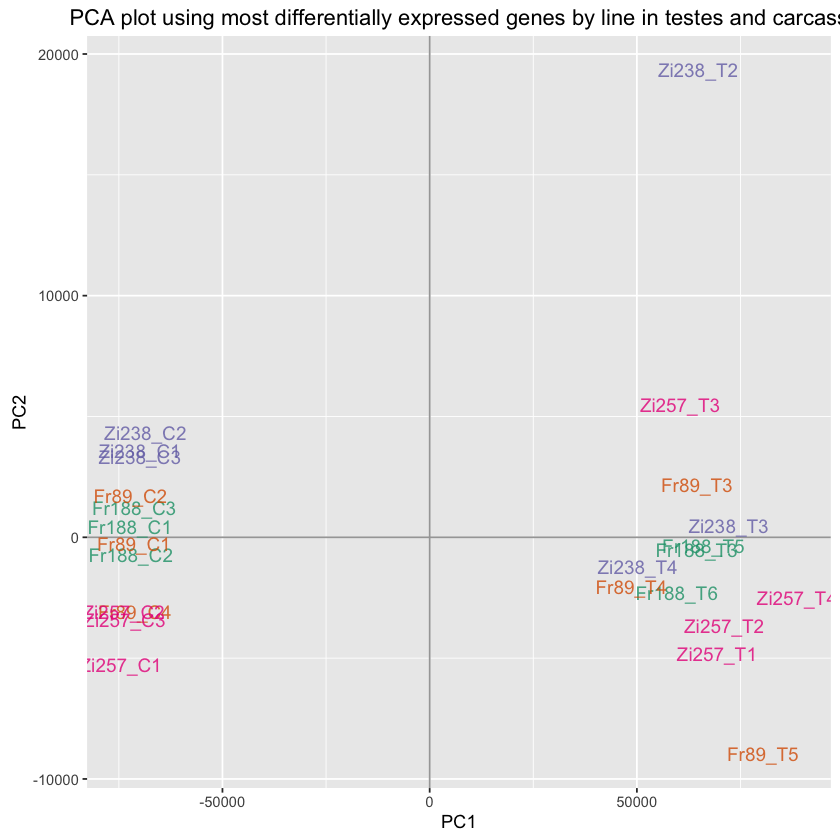

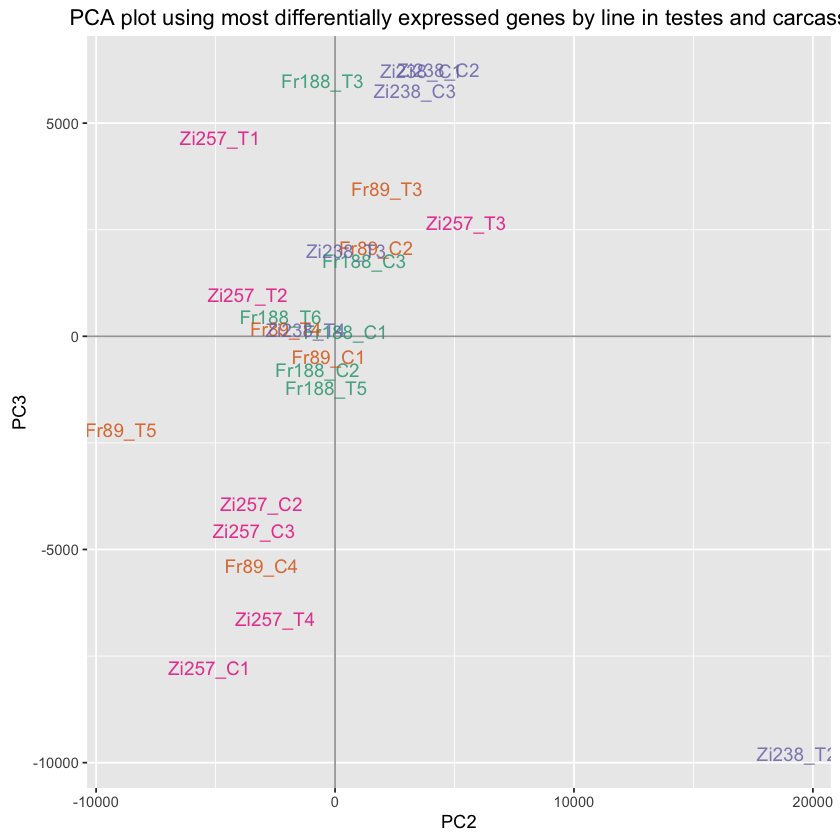

In [229]:
cols=c(rep('#1B9E77',6), rep('#D95F02',6),rep('#7570B3',6),rep('#E7298A',7))


#get normalized counts
pca1<-prcomp(t(as.matrix(nCountsBoth[SigsInCandT, ])))
scores = as.data.frame(pca1$x)

# plot of observations
ggplot(data = scores, aes(x = PC1, y = PC2, label = rownames(scores))) +
  geom_hline(yintercept = 0, colour = "gray65") +
  geom_vline(xintercept = 0, colour = "gray65") +
  geom_text(colour =cols, alpha = 0.8, size = 4) +
  ggtitle("PCA plot using most differentially expressed genes by line in testes and carcass")

# plot of observations
ggplot(data = scores, aes(x = PC2, y = PC3, label = rownames(scores))) +
  geom_hline(yintercept = 0, colour = "gray65") +
  geom_vline(xintercept = 0, colour = "gray65") +
  geom_text(colour =cols, alpha = 0.8, size = 4) +
  ggtitle("PCA plot using most differentially expressed genes by line in testes and carcass")



# Comparing found DE genes (in carcass data) to Sackton GBE meta-analysis YRV genes

### Grabbing and updating Sackton GBE genes

The supplementary material of the Sackton GBE meta-analysis is linked here: "http://gbe.oxfordjournals.org/content/suppl/2013/01/12/evt005.DC1/sup_file_1.tsv".  We load it as a table of `Sacktongenes`

In [40]:
Sacktongenes <- read.table(
  "http://gbe.oxfordjournals.org/content/suppl/2013/01/12/evt005.DC1/sup_file_1.tsv",
  sep="\t", header=TRUE)


In [41]:
head(Sacktongenes)
length(Sacktongenes[,1])
#There are 4271 genes

fbgn chr sigclass all.sig  dmel.avg         cv  cellular_loc dmsp
1 FBgn0000008  2R specific       1 0.4699436 0.46904991      membrane   no
2 FBgn0000014  3R     none       0 0.4496924 0.14027248       nucleus   no
3 FBgn0000036  3R     none       0 0.3308644 0.11442119      membrane   no
4 FBgn0000038  3L     none       0 0.4913641 0.09915834      membrane   no
5 FBgn0000042   X specific       1 0.7656141 0.28474085       nucleus   no
6 FBgn0000043  2R     none       0 0.5226461 0.05774715 intracellular   no
   FbtrLen NumInt FirstIntLen AveIntLen color     m0W  RecomRP intergenic.dist
1 4.554513      9    2.898725  3.537525 BLACK      NA       NA        0.000000
2 4.344923      5    3.010300  3.545851  BLUE 0.03038 2.512977        4.261525
3 4.745894      9    3.580012  3.763794 BLACK 0.00465 3.205108        0.000000
4 3.822560      6    1.806180  2.844166 BLACK 0.01793 3.278810        3.538448
5 3.594282      1    3.224533  3.224533   RED      NA       NA        4.254741
6 3.249687      1    2.190332  2.190332   RED      NA       NA        0.000000
       gpmb window11.length transcript.num    tau.avg     mf.pc1    exp.pc1
1 -3.752847        4.795414              3 0.35434291 -0.9493064 -0.6130555
2 -3.899215        5.167704              4 0.63830078 -0.3405483 -0.6803284
3 -3.724689        5.151214              2 0.90016456  0.1946668 -0.4574673
4 -3.823899        4.886101              4 0.87540349  0.4023412 -0.3782089
5 -3.881319        4.878114              4 0.07764047 -0.9959554  6.0292924
6 -4.097681        4.895671              1 0.17932247 -0.6554756  1.4131835
  postmei.ratio    h2m     Embryo      Larvae      pupae expdivtot.m het
1   -0.21237714     NA   2.185172   0.8446358   2.661192          NA rep
2    0.18745863     NA  11.936504   5.9847983   7.531940     1.58108 rep
3   -0.06374388     NA   2.522274   2.0797408   2.186969     1.39626 rep
4    0.04022984 0.3430  13.921220   7.0573650  18.517542     0.91937 rep
5    0.04507071 0.2260  64.832992 111.3475167 181.535500          NA act
6   -0.03750336 0.0683 408.235667 261.4169333 485.385000          NA act
  Ycongo.Ymass Ycongo.Ycs Ycongo.Yz53 Ycongo.Y4361  Ymass.Ycs Ymass.Yz53
1  -0.26684367  0.2458371  -0.1283616   0.22513673  0.4947913  0.1404150
2  -0.19038851  0.4116478   0.5458252   0.88353507  0.5807296  0.7122474
3   0.01894574 -0.1830603   0.3326228  -0.03683723 -0.1852797  0.2854456
4  -0.48513005  0.4441997   0.1915662   0.66581431  0.8969052  0.6633139
5   0.03105632  1.6522717   0.5284585   0.66863585  1.5625156  0.4767579
6   0.57013936  0.8584109   0.8178305   0.18875263  0.2764599  0.2219468
  Ymass.Y4361    Ycs.Yz53   Ycs.Y4361 Yz53.Y4361  bl08.avg  bl08.max      H7.H5
1  0.46526995 -0.36644085 -0.02857002  0.3456872 0.2707353 0.4947913 0.12149559
2  0.99979853  0.11867475  0.42217409  0.3209955 0.5186016 0.9997985 0.67926844
3 -0.04776916  0.48576516  0.14030554 -0.3463818 0.2062413 0.4857652 0.06543646
4  1.08284424 -0.25447730  0.18871302  0.4587337 0.5331698 1.0828442 0.49366036
5  0.58775852 -1.12377646 -0.97561634  0.1290610 0.7735908 1.6522717 0.39432065
6 -0.37533797 -0.06090888 -0.65405074 -0.6233351 0.4647173 0.8584109 0.25963247
       H15.H5    H23.H5     H15.H7      H23.H7     H23.H15     h.avg     h.max
1 -0.07642945 0.1565460 -0.1655711  0.07306886  0.30287465 0.1493309 0.3028747
2  0.57386253 0.1892679  0.1577600 -0.27016920 -0.54828578 0.4031023 0.6792684
3  0.19256019 0.2378249  0.1618607  0.18493349  0.03378408 0.1460667 0.2378249
4  0.21187144 0.3096416 -0.1017699 -0.04243476  0.07781128 0.2061982 0.4936604
5  0.85336592 0.5858677  0.6542870  0.30943171 -0.42387119 0.5368574 0.8533659
6  0.63810079 0.4259920  0.5168607  0.24381656 -0.33910791 0.4039184 0.6381008
  XXYcongo.XXYohio XXYcongo.XXYindia XXYcongo.XXYzimb XXYindia.XXYohio
1       -2.8200671        -1.5560442       -1.2414400      -0.31372777
2       -1.4758109        -0.1619016        0.2648136      -0.82472873
3        0.7343329        -0.1537920       -0.52425

[1] 4271

In [43]:
#colnames(Sacktongenes)

Genes for which all.sig==1 are YRV genes.  There are 678 YRV genes.  We display the first 10.  The variable `YRVgenes` is a list of genes described in the Sackton GBE meta-analysis.

In [122]:
YRVgenes<-Sacktongenes[Sacktongenes$all.sig==1,]$fbgn
length(YRVgenes)


[1] 678

These genes might have names that are out of date.  We are going to update the names using flybase.

In [47]:
UpdatedGBEtable<-read.table("~/Downloads/FlyBase_IDs-5.txt", sep="\t")
head(UpdatedGBEtable)

V1          V2          V3      V4
1 FBgn0037191 FBgn0037191 FBgn0037191 CG14448
2 FBgn0033320 FBgn0033320 FBgn0033320  CG8586
3 FBgn0051156 FBgn0051156 FBgn0051156 CG31156
4 FBgn0039236 FBgn0265266 FBgn0265266 CG13639
5 FBgn0261992 FBgn0261992 FBgn0261992 CG42810
6 FBgn0038220 FBgn0038220 FBgn0038220 CG12207

 In the updated gene names, there are 4279 genes.  Sometimes multiple genes were mapped to 1, and sometimes 1 gene was mapped to multiple.  The new updated genes analyzed are listed in variable `AllUpdatedGBEGenes`

In [108]:
length(UpdatedGBEtable$V1) 
length(unique(UpdatedGBEtable$V1)) 
length(unique(UpdatedGBEtable$V3))
AllUpdatedGBEGenes<-unique(UpdatedGBEtable$V3)

[1] 4285

[1] 4271

[1] 4279

So actually the number of YRV genes is 684 instead of 678.  These are stored in the variable `newYRVgenes`

In [123]:
newYRVgenes<-unique(UpdatedGBEtable[UpdatedGBEtable$V1 %in% YRVgenes, ]$V3)
length(newYRVgenes)
length(YRVgenes)

[1] 684

[1] 678

We now consider nonYRV genes updated from the table in Sackton's GBE paper.  We find there are 3595 of them.  These are stored in the variable `newnonYRVgenes`

In [177]:
nonYRVgenes<-Sacktongenes[Sacktongenes$all.sig==0,]$fbgn
newnonYRVgenes<-unique(UpdatedGBEtable[UpdatedGBEtable$V1 %in% nonYRVgenes, ]$V3)
length(newnonYRVgenes)
length(nonYRVgenes)

[1] 3595

[1] 3593

[1] FBgn0037191 FBgn0036016 FBgn0031751 FBgn0264305 FBgn0264307 FBgn0038481
 [7] FBgn0031701 FBgn0035198 FBgn0033787 FBgn0052351
4279 Levels: FBgn0000008 FBgn0000014 FBgn0000036 FBgn0000038 ... FBgn0283521

### Turning back our attention to genes in our analysis

There are 463 transcripts that statisically significantly (adjusted p-val <.05) show differential expression by line in carcass data (according to our analysis in the first section).  

In [121]:
length(NoNAC[NoNAC$padj<.05,][,1])

[1] 463

There are 150 transcripts that are significant in the testes data.  

In [124]:
length(NoNAT[NoNAT$padj<.05,][,1])

[1] 150

If we consider both carcass and testes, there are 607 significant transcripts.  So there are 6 transcripts that are significant both in testes data and carcass data.

In [125]:
length(SigsInCandT)
150+463-607

[1] 607

[1] 6

### Converting transcripts in our analysis to genes

I copy paste the transcripts from all the genes in our analysis into http://flybase.org/static_pages/downloads/IDConv.html. As a result, I get a table of conversions from Fbtr to FBgn stored in file ~/Downloads/FlyBase_IDs-7.txt.  I stored all these genes in `AllUpdatedOurGenes`

In [169]:
UpdatedTranscripts<-read.table("~/Downloads/FlyBase_IDs-7.txt", sep="\t")  #IMPORTANT: I replaced all ' in the table by 0000000000.  If I didn't the table read was messed up
length(unique(UpdatedTranscripts$V1))
length(unique(UpdatedTranscripts$V3))
head(UpdatedTranscripts)

newSigGenesC<-unique(UpdatedTranscripts[UpdatedTranscripts$V1 %in% rownames(NoNAC[NoNAC$padj<.05,]), ]$V3)
newSigGenesT<-unique(UpdatedTranscripts[UpdatedTranscripts$V1 %in% rownames(NoNAT[NoNAT$padj<.05,]), ]$V3)
newSigGenes<-union(newSigGenesC, newSigGenesT)
newUnSigGenesC<-unique(UpdatedTranscripts[UpdatedTranscripts$V1 %in% rownames(NoNAC[NoNAC$padj>=.05,]), ]$V3)
newUnSigGenesT<-unique(UpdatedTranscripts[UpdatedTranscripts$V1 %in% rownames(NoNAT[NoNAT$padj>=.05,]), ]$V3)
newUnSigGenes<-intersect(newUnSigGenesC, newUnSigGenesT)
length(newSigGenes) + length(newUnSigGenes)

#Ther are are a bunch of genes with NA here for p_adj.  What do we do with those?


[1] 30433

[1] 13904

V1          V2          V3      V4
1 FBtr0302974 FBtr0302974 FBgn0261625     GLS
2 FBtr0335289 FBtr0335289 FBgn0033051  Strica
3 FBtr0344010 FBtr0344010 FBgn0038402    Fer2
4 FBtr0301882 FBtr0301882 FBgn0020440     Fak
5 FBtr0074312 FBtr0074312 FBgn0010412  RpS19a
6 FBtr0335463 FBtr0335463 FBgn0264988 CG44139

[1] 11765

## Combining GBE dataset and Our dataset into Fisher's table

The number of genes in common between the GBE dataset and our dataset are:

Is that more than we would expect by chance?  We need the following pieces of information:
- \# YRVgenes intersect OurDEGenes : 71
- \# YRVgenes intersect !OurDEGenes: 576
- \# !YRVgenes intersect OurDEGenes: 212
- \# !YRVgenes union !OurDEGenes :  3348

In [187]:
AllGBEGenes<-union(newYRVgenes, newnonYRVgenes)
AllOurGenes<-union(newSigGenes, newUnSigGenes)
length(intersect(AllGBEGenes, AllOurGenes))

length(intersect(newYRVgenes, newSigGenes))
length(intersect(newYRVgenes, newUnSigGenes))
length(intersect(newnonYRVgenes, newSigGenes))
length(intersect(newnonYRVgenes, newUnSigGenes))

[1] 4031

[1] 71

[1] 576

[1] 212

[1] 3348

In [189]:
forFishersTest<-matrix(c(71, 212, 576, 3348), nrow = 2, 
                       dimnames = list(c("YRVgenesYes", "YRVgenesNo"),c("OurDEGenesYes", "OurDEGenesNo")))
forFishersTest

OurDEGenesYes OurDEGenesNo
YRVgenesYes            71          576
YRVgenesNo            212         3348

In [190]:
fisher.test(forFishersTest, or = 1, alternative = "two.sided", conf.int = TRUE, conf.level = 0.95)


	Fisher's Exact Test for Count Data

data:  forFishersTest
p-value = 1.119e-05
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.444909 2.598058
sample estimates:
odds ratio 
  1.946327 


The p-value is 1.119*10^-5 : we can reject the null of independence in the number of cells in the table at the 1% level

# Ignore everything below

In [ ]:
newOurSigGenes<-unique(AllOurGenes[AllOurGenes$V1 %in% SigsInCandT, ]$V3)

I copy paste the T and C significant transcripts above into http://flybase.org/static_pages/downloads/IDConv.html . As a result, I get a table of conversions from Fbtr to FBgn stored in file ~/Downloads/FlyBase_IDs-6.txt, and read as table into variable `OurMostSignificantCandTConversionTable`.

In [77]:
OurMostSignificantCandTConversionTable<-read.table("~/Downloads/FlyBase_IDs-6.txt", sep="\t")
head(OurMostSignificantCandTConversionTable)

V1          V2          V3      V4
1 FBtr0079856 FBtr0079856 FBgn0051709 CG31709
2 FBtr0100482 FBtr0100482 FBgn0014869 Pglym78
3 FBtr0307372 FBtr0307372 FBgn0263132    Cht6
4 FBtr0085462 FBtr0085462 FBgn0039685  Obp99b
5 FBtr0080184 FBtr0080184 FBgn0069354  Porin2
6 FBtr0305335 FBtr0305335 FBgn0040628 CG18672

Next we check how many unique genes there are (more than one transcripts could correspond to a single gene).  

In [79]:
length(OurMostSignificantCandTConversionTable$V3)
length(unique(OurMostSignificantCandTConversionTable$V3))

[1] 607

[1] 576

It looks like our 607 statistically significant transcripts correspond to 576 genes.  We store these in the variable `OurDEGenes`.

In [80]:
OurDEGenes<-unique(OurMostSignificantCandTConversionTable$V3)

How many of OurDEGenes are in YRVgenes?  The answer (as can be seen in the cell below) is 71.

In [120]:
length(intersect(newYRVgenes, OurDEGenes))
length(intersect(newnonYRVgenes, OurDEGenes))
length(AllUpdatedOurGenes[AllUpdatedOurGenes %in% OurDEGenes])
setdiff(OurDEGenes, AllUpdatedOurGenes[AllUpdatedOurGenes %in% OurDEGenes])
length(OurDEGenes)
length(intersect(UpdatedGBEtable$V3, OurDEGenes))
length(OurDEGenes)
length(UpdatedGBEtable$V3)
#intersect(UpdatedGBEtable$V3, OurDEGenes)

[1] 71

[1] 212

[1] 575

[1] "FBgn0283521"

[1] 576

[1] 283

[1] 576

[1] 4285

Is that more than we would expect by chance?  We need the following pieces of information:
- \# YRVgenes intersect OurDEGenes : 71
- \# YRVgenes intersect !OurDEGenes: 684-66 = 618
- \# !YRVgenes intersect OurDEGenes: 212
- \# !YRVgenes union !OurDEGenes :  - (678 + 488 - 57)

In order to calculate ???, we must take all genes that are the same in both datasets (there are maximum 4271, because there are 4271 in the meta-analysis dataset).  This will involve turning all of our transcripts into genes and looking at the intersection between both datsets.  For now, I'm just going to assume that ???==4271.

So temporarily, we have: 
- \# !YRVgenes union !OurDEGenes : 4271 - (678 + 488 - 57) = 3162


In [83]:
684-66

[1] 618

In [ ]:
forFishersTest<-matrix(c(57, 431, 621, 3162), nrow = 2, 
                       dimnames = list(c("YRVgenesYes", "YRVgenesNo"),c("OurDEGenesYes", "OurDEGenesNo")))
forFishersTest


We are now going to run Fisher's exact test.

In [ ]:
fisher.test(forFishersTest, or = 1, alternative = "two.sided", conf.int = TRUE, conf.level = 0.95)

The p-value is .00686: we can reject the null of independence in the number of cells in the table at the 5% level (yay!).  

(I'll come back to this -- I still need to replace "???" with the real value.)

Coming back to this -- it looks like there are many more genes considered in our dataset of transcripts (13903 instead of 4271).  [We find that there are 30433 transcripts that map to 13903 genes] Is this correct?  

In [ ]:
AllOurGenes<-read.table("~/Downloads/FlyBase_IDs-4.txt", sep="\t")
length(unique(AllOurGenes$V1))
head(AllOurGenes)

length(intersect(Sacktongenes$fbgn, AllOurGenes$V1))
#length(intersect(YRVgenes, OurDEGenes))

We replace '???' with 4088, the length of the intersection of `Sacktongenes$fbgn, AllOurGenes$V1`.

In [ ]:
4088 - (678 + 488 - 57)
forFishersTest<-matrix(c(57, 431, 621, 2979), nrow = 2, 
                       dimnames = list(c("YRVgenesYes", "YRVgenesNo"),c("OurDEGenesYes", "OurDEGenesNo")))
forFishersTest
fisher.test(forFishersTest, or = 1, alternative = "two.sided", conf.int = TRUE, conf.level = 0.95)